<h1 style="text-align: center;">Descenso de gradientes estocástico (SGD)</h1>
<br>
<p style="text-align: center;">Carlos Pita</p>
<p style="text-align: center;">Digital House</p>
<p style="text-align: center;">Julio 2019</p>

## Elementos del problema

* Muestra aleatoria $z_1, \dots, z_n = (x_1, y_1), \dots, (x_n, y_n)$.
* Función de pérdida $l(\hat{y}, y)$ donde $\hat{y}$ es nuestra predicción.
* Familia de soluciones posibles $f_w$, *i.e.* funciones indexadas por parámetros $w \in W$.

Querríamos encontrar $w^\star$ tal que minimice la pérdida esperada $E(f_{w^\star}) = \mathbb{E}_Z(l(f_{w^\star}(X), Y))$ sobre la distribución de $Z = (X, Y)$.

Como desconocemos esa distribución, buscamos $f_{w_n}$ aproximando la esperanza por el promedio muestral $E(f_{w_n}) = \frac{\sum_{i=1}^n l(f_{w_n}(x_i), y_i)}{n}$.

## Descenso de gradientes (GD)

Si $l$ es diferenciable, podemos buscar $w^\star$ mediante descenso de gradientes:

$$
w_{t+1} = w_t - \eta_t \frac{\partial\left({\sum_{i=1}^n  l(f_w(x_i), y_i)}\right)}{\partial w}
        = w_t - \eta_t \sum_{i=1}^n \frac{\partial{l(f_w(x_i), y_i)}}{\partial w}
$$

para alguna agenda decreciente de tasas de aprendizaje $\eta_1,\dots,\eta_t,\dots$.

## Descenso de gradientes estocástico (SGD)

En la expresión

$$\sum_{i=1}^n \frac{\partial{l(f_w(x_i), y_i)}}{\partial w}$$

es necesario calcular un gradiente por cada observación de la muestra.

La dirección de descenso "balancea" entonces las pérdidas de todas las observaciones.

Esto es bueno, pero puede ser muy caro computar $n$ gradientes en cada descenso.

## Descenso de gradientes estocástico (SGD)

Una idea es tomar una observación al azar y descender para intentar reducir su pérdida, ignorando las demás. En este sentido el descenso es aleatorio o estocástico.

$$
w_{t+1} = w_t - \eta_t \frac{\partial{l(f_w(x_k), y_k)}}{\partial w}
$$

con $k = \text{random}({1,\dots,n})$.

La intuición es que si en cada paso mejoramos una observación al azar, después de cierta cantidad de pasos vamos a haber mejorado, en promedio, los tipos de observación más frecuentes o representativos.

Esto es "barato" y puede funcionar razonablemente bien para un número enorme de observaciones. De hecho, vamos a ver que en un sentido es independiente de la cantidad total de datos.

## Descenso de gradientes estocástico (SGD)

Scikit ofrece dos implementaciones de estimadores SGD `en sklearn.linear_model`, que a su vez implementan distinas funciones de pérdida. Algunos ejemplos:
* `SGDClassifier`
    * `loss="hinge"`: support vector machine (SVM) lineal. Es el default.
    * `loss="log"`: regresión logística.
* `SGDRegressor`
    * `loss="squared_loss"`: mínimos cuadrados ordinarios (OLS). Es el default.
    * `loss="huber"`: regresión robusta frente a outliers.

Internamente todos estos estimadores comparten la misma implementación. Esto demuestra la flexibilidad y simplicidad del enfoque SGD.

```python
from sklearn.linear_model import SGDClassifier

reglog = SGDClassifier(loss="log")
```

## Análisis de convergencia

La situación es ahora:

1. Cada iteración es $n$ veces más barata de computar.
2. Cada iteración usa la información de $n$ veces menos observaciones.
3. Cada iteración remuestrea la muestra introduciendo así un nuevo componente de ruido.

Ganamos o perdimos? Para responderlo tenemos que comparar la convergencia de GD y SDG.

## Análisis de convergencia

Siendo $f^\star$ el verdadero (y desconocido!) modelo, vamos a descomponer en tres partes el error relativo debido a que lo estimamos optimizando iterativamente sobre $f_w$ con $w \in W$, dada una muestra de tamaño $n$:

$$
E(f_{w_n}) - E(f^\star) = err_{app} + err_{est} + err_{opt}
$$
donde:
* $err_{app}$ es el error de aproximación, que solo podemos reducir ampliando la familia $W$.
* $err_{est}$ es el error de estimación, que reducimos aumentando el tamaño de muestra $n$.
* $err_{opt}$ es el error de optimización, que reducimos aumentando el número de iteraciones del optimizador $t$.

## Análisis de convergencia

Considerando fijo $err_{app}$ (es decir, considerando fija la familia $W$), buscamos un balance óptimo entre $err_{est}$ y $err_{opt}$.

Pero tenemos restricciones:
* $N$ es el tamaño máximo de muestra (no tenemos más datos).
* $T$ es el tiempo máximo de ejecución (no tenemos más tiempo / capacidad de cómputo).

Con esto presente podemos distinguir entre dos tipos de problemas de aprendizaje:
* A pequeña escala: la restricción activa es $N$ ("sobra el tiempo").
* A gran escala: la restricción activa es $T$ ("sobran los datos").

## Análisis de convergencia

Sea $\rho = err_{est} + err_{opt}$, la siguiente tabla compara el número de iteraciones y el tiempo total asintóticos para conseguir un determinado $\rho$ en GD *vs.* SGD:

<table>
    <thead><tr><th></th><th>GD</th><th>SGD</th></tr></thead>
    <tbody>
    <tr><td><b>Tiempo por iteración</b></td>
        <td style="width:200px">n</td>
        <td style="width:200px">1</td></tr>
    <tr><td><b>Número de iteraciones</b></td>
        <td>$O(log(1/\rho))$</td>
        <td>$O(1/\rho)$</td></tr>
    <tr><td><b>Tiempo total</b></td>
        <td>$O(n\,log(1/\rho))$</td>
        <td>$O(1/\rho)$</td></tr>
    </tbody>
</table>

Podemos ver que el tiempo asintótico total para reducir $\rho$ es logarítmicamente menor en GD pero, por otro lado, en SGD no depende del tamaño de la muestra $n$.

Por ejemplo, si tenemos 1,000,000 observaciones y queremos aumentar la precisión en 100, necesitamos alrededor de $20 \approx 100/\log(100)$ veces más iteraciones en SGD, pero cada iteración de GD lleva 1,000,000 pasos más. No tiene mucho sentido esperar tanto para descender! 

## Tasa de aprendizaje

Si bien las condiciones sobre la tasa de aprendizaje que garantizan convergencia teórica son bastante laxas, en la práctica la velocidad de convergencia es un problema importante.

Como para cualquier algoritmo de descenso de gradientes, es fundamental normalizar primero las features. Así evitamos que algunos features monopolicen el descenso por cuestiones de escala.

La tasa debe ser decreciente (o pequeña y constante, si estamos dispuestos a tolerar cierta divergencia irreductible), pero:
* Si decrece demasiado rápido puede frenar el descenso lejos del óptimo.
* Si decrece demasiado lento puede hacer oscilar al optimizador alrededor del óptimo.

## Tasa de aprendizaje

Existen técnicas adaptativas como AdaGrad que resuelven el problema anterior computando progresivamente una tasa de aprendizaje óptima para cada feature, al precio de uno o dos hiperparámetros globales. Estas técnicas son *muy efectivas*.

La oferta de Scikit es más tradicional:
* `learning_rate=constant`: $\eta$ = `eta0`.
* `learning_rate=optimal` (default para clasificación): $\eta$ = `1 / (alpha * (t + t_0))`, con `t_0` seleccionado mediante una heurística propuesta por Léon Bottou.
* `learning_rate=invscaling` (default para regresión): $\eta$ = `eta0 / pow(t, power_t)`. Por default, `power_t=0.5`.
* `learning_rate=adaptive`: $\eta$ arranca en `eta0` y se va reduciendo paulatinamente si después de `n_iter_no_change` no hay mejoras.

**YMMV**

## Aprendizaje online

Supongamos que nuestra muestra no está completamente dada de antemano, sino que es producida gradualmente por un proceso generador aleatorio (por ejemplo, transacciones en un mercado).

Si este proceso genera observaciones independientes entre sí, el modelo es el mismo que antes, solo que ahora lo pensamos diferente: en lugar de muestrear una por una las observaciones ya dadas, las recibimos al azar de la "naturaleza". 

Por lo tanto SGD se puede aplicar a procesos "ongoing". A esta situación la llamamos *aprendizaje online* (no tiene nada que ver con que este online en Internet!).

```python
x, y = next_observation()
reglog.partial_fit(x, y)
x, y = next_observation()
reglog.partial_fit(x, y)
```

## Aprendizaje online

Recordemos que SGD está calculando el gradiente para una observación a la vez. Esto es muy rápido pero los descensos se pierden de "balancear" la pérdida de distintas observaciones.

Podemos mejorar la performance considerando varias observaciones al mismo tiempo. Por ejemplo, si nuestro dataset contiene billones (o infinitos!) datos, agruparlos de a 1000 apenas modifica la performance del algoritmo, pero puede acelerar significativamente su convergencia.

A estos paquetes de observaciones los llamamos *minibatches*.

Desde el punto de vista de Scikit, no cambia mucho:

```python
X, y = next_minibatch()
reglog.partial_fit(X, y)
X, y = next_minibatch()
reglog.partial_fit(X, y)
```

## Validación Progresiva

Cuando hacemos aprendizaje online existe un "truco" para estimar el error de generalización. En cierto sentido, es similar a lo que hacíamos con LOOCV (leave one out cross-validation).

Cada vez que recibimos una nueva obervación $z_{t+1} = x_{t+1}, y_{t+1}$ podemos, antes de efectuar el update $w_t \rightarrow w_{t+1}$, computar la pérdida $l(f_{w_t}(x_{t+1}), y_{t+1})$.

De esta forma generamos una secuencia de estimaciones del error esperado. Podemos guardar únicamente una media móvil, o media y varianza móviles, o toda la secuencia.

```python
x, y = next_observation()
loss_sum += log_loss(y, reglog.predict(x))
loss_n += 1
print("Average loss:", loss_sum / loss_n)
reglog.partial_fit(x, y)
```

Notar que, al principio, el estimador aun ha aprendido de pocas observaciones. Es conveniente "esperar un poco" antes de empezar a computar la media móvil. Asimismo, es conveniente que esta media móvil tenga "memoria limitada" (por ejemplo, una caída exponencial).

## Regularización

La penalización $L_2$ es continuamente diferenciable y agregarla a la función de pérdida no presenta mayores problemas.

La penalización $L_1$ no es diferenciable en el 0. Pero incluso si usáramos subgradientes, en el mejor de los casos fluctuaríamos entre coeficientes casi nulos, pero nunca -excepto de causalidad- exactamente nulos.

Existen heurísticas obvias pero *malas*: truncar a 0 por debajo de cierto threshold, o truncar si un coeficiente cambia de signo. Cada vez que truncamos *acumulamos errores* de una iteración a otra.

La estrategia que usa Scikit es truncar usando la penalización $L_1$ acumulada (sin truncar). Otro enfoque, que proviene de la literatura de optimización convexa online (OCO), consiste en reformular el descenso como un problema llamado Follow the Regularized Leader - Proximal (FTRL-P), que regulariza en cada paso la secuencia completa de gradientes hasta el momento, en lugar de cada descenso.

## Regularización

Scikit implementa ElasticNet, una combinación ponderada entre $L_1$ y $L_2$. La combinación es controlada por dos hiperparámetros:
* `l1_ratio` se mueve entre 0 y 1, con 0 correspondiendo a solo Ridge y 1 a solo Lasso.
* `alpha` controla el nivel de regularización (sea Ridge, Lasso o una combinación entre ambas).

La siguiente figura muestra las curvas de nivel de radio 1 para las distintas penalizaciones:

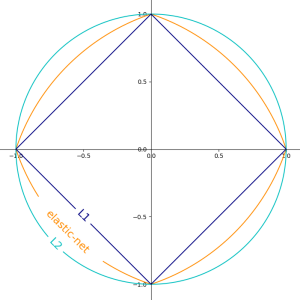

## Bibliografía

* Bottou "Large-Scale Machine Learning with Stochastic Gradient Descent" [Link](https://leon.bottou.org/publications/pdf/compstat-2010.pdf)
* Bottou, Bousquet "The Tradeoffs of Large Scale Learning" [Link](https://papers.nips.cc/paper/3323-the-tradeoffs-of-large-scale-learning.pdf)
* Duchi, Hazan, Singer. “Adaptive subgradient methods for online learning and stochastic optimization” [Link](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
* McMahan “A unified view of regularized dual averaging and mirror descent with implicit updates” [Link](http://www.jmlr.org/proceedings/papers/v15/mcmahan11b/mcmahan11b.pdf)
* McMahan et al. “Ad click prediction: a view from the trenches” [Link](https://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
* Tsuruoka "Stochastic Gradient Descent Training for L1-regularized Log-linear Models with Cumulative Penalty" [Link](https://www.aclweb.org/anthology/P09-1054)
* Scikit User Guide "SGD" [Link](https://scikit-learn.org/stable/modules/sgd.html)
